In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os

In [136]:
run_range = range(0,50)
blocks_range = range(1,6)
simulation_range = [0,1]#range(8,10)

# run_range = range(0,5)
# blocks_range = range(1,2)
# simulation_range = [0,1,8,9]#range(0,1)

num_samples = 20000;

alphas = np.zeros((num_samples, len(run_range), len(blocks_range), len(simulation_range), 3))
taus   = np.zeros((num_samples, len(run_range), len(blocks_range), len(simulation_range)))

alphas_true = np.zeros((len(simulation_range), 3))
taus_true = np.zeros((len(simulation_range)))


results_directory = "Results/Simulations"

depth = 3
alpha_strs = ["no", "one_back", "two_back", "three_back"]
alpha_names = ["alpha_concentration_" + alpha_strs[dd] + "_context" for dd in range(depth)]


for sim_idx, sim_num in enumerate(simulation_range):
    for run_idx, run_num in enumerate(run_range):
        for block_idx, block_num in enumerate(blocks_range):
            filename = "{results_directory}/Sim_{sim_num}_block_{block_num}_run_{run_num}.pkl".format(results_directory=results_directory, sim_num=sim_num, block_num=block_num, run_num=run_num)
            if(not os.path.isfile(filename)):
                raise RuntimeError("Results file not found: " + filename)
                # throw error
            
            # load file
            with open(filename, "rb") as results_file:
                results = pickle.load(results_file)


                nwarmup = results["samples"]["num_warmup_samples"]
                for ii in range(3):
                    alphas[:,run_idx,block_idx,sim_idx,ii] = results["samples"]["alphas"][nwarmup:,ii]
                taus[:,run_idx,block_idx,sim_idx] = np.exp(results["samples"]["log_taus"][nwarmup:,0])

                for ii, pname in enumerate(alpha_names):
                    alphas_true[sim_idx,ii] = results["true_parameters"][pname]
                taus_true[sim_idx] = results["true_parameters"]["within_session_A_time_constant"]

                connection_data = results["simulation_info"]["connection_data"]
                #print("cts = " + str(np.sum(connection_data["C_y"][:,-1] == 0)) + ", "  + str(np.sum(connection_data["C_y"][:,-1] == 1)) + ", "  + str(np.sum(connection_data["C_y"][:,-1] == 2)))


In [137]:
median_alphas = np.median(alphas,axis=0)
median_taus = np.median(taus,axis=0)


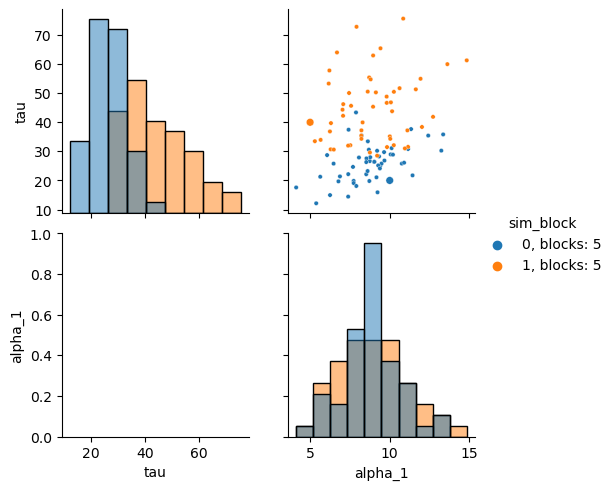

In [141]:
sim_nums = [0,1];
block_nums = [5,5];
# sim_nums = [4,5,6,7];
# block_nums = [2,2,2,2];

true_size = 30;
sim_size = 10;

df = pd.DataFrame(columns=["alpha_0", "alpha_1", "alpha_2", "tau", "sim", "blocks", "size", "true"])
for sim_num, block_num in zip(sim_nums, block_nums):
    sim_idx   = simulation_range.index(sim_num) 
    block_idx = blocks_range.index(block_num)

    vars_1 = [median_alphas[:,block_idx,sim_idx,:].squeeze(), median_taus[:,block_idx,sim_idx][:,np.newaxis], 
                sim_num*np.ones((median_taus.shape[0],1), dtype=int),
                block_num*np.ones((median_taus.shape[0],1), dtype=int),
                sim_size*np.ones((median_taus.shape[0],1), dtype=int), np.zeros((median_taus.shape[0],1), dtype=bool)]

    df_c = pd.DataFrame(np.concatenate(vars_1,axis=1), columns=["alpha_0", "alpha_1", "alpha_2", "tau", "sim", "blocks", "size", "true"])
    df = pd.concat([df,df_c])

    df_c = pd.DataFrame(np.array([alphas_true[sim_idx,0], alphas_true[sim_idx,1], alphas_true[sim_idx,2], taus_true[sim_idx],
                    sim_num, block_num, true_size, True])[np.newaxis,:],
                    columns=["alpha_0", "alpha_1", "alpha_2", "tau", "sim", "blocks", "size", "true"])
    df = pd.concat([df,df_c])
df = df.astype({'sim':'int', "blocks" : "int"})
df["sim_block"] = "sim " + df["sim"].astype("string") + ", blocks: " + df["blocks"].astype("string")
df["sim_block"][df["true"]] = "true sim " + df["sim"][df["true"]].astype("string")
g = sns.PairGrid(df, diag_sharey=False, hue="sim", vars=["alpha_0", "alpha_1", "alpha_2", "tau"])
# g = sns.PairGrid(df, diag_sharey=False, hue="sim_block", vars=[ "tau", "alpha_1"])
g.map_upper(sns.scatterplot, s=df["size"])
g.map_diag(sns.histplot)
g.add_legend()



In [139]:
A = results["simulation_info"]["connection_data"]["C_ctx"]
print(A)

[[-2 -3 -3]
 [-2  1 -3]
 [-2  0  1]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  2  0]
 [-2  0  2]
 [-2  2  0]
 [-2  0  2]
 [-2  2  0]
 [-2  0  2]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  1  0]
 [-2  2  1]
 [-2  0  2]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  2  0]
 [-2  0  2]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  2  0]
 [-2  0  2]
 [-2  1  0]
 [-2  0  1]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [-2